In [1]:
import pandas as pd
import os
import warnings
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

plt.style.use('classic')

warnings.filterwarnings('ignore')


In [2]:
random.seed(42)

In [4]:
if os.getcwd().split('/')[-1] != 'market-congestion':
    os.chdir('..')

print(f'working directory: {os.getcwd()}')

working directory: /Users/crinstaniev/Dev/market-congestion


In [5]:
train_data = pd.read_pickle('data/train.pkl')
test_data = pd.read_pickle('data/test.pkl')

# Classification

## Naïve Algorithm

In [6]:
MA_WINDOW = 10

In [7]:
prev_theta = test_data['congested'].shift(1).rolling(window=MA_WINDOW)
congested_count = prev_theta.sum().dropna()

y_pred = congested_count >= 5
y_true = test_data.loc[y_pred.index]['congested']

### Performace Metrics

In [8]:
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [9]:
# this class is only for performance benchmark
class NaiveAlgorithm(BaseEstimator):
    def __init__(self, y_pred):
        self.y_pred = y_pred
        self._estimator_type = 'classifier'
        
    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.y_pred.loc[X].values.astype(int)
    

In [10]:
mdl = NaiveAlgorithm(y_pred=y_pred)

In [11]:
X_test = y_true.index.values

classification report

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.97      0.88      8435
        True       0.16      0.03      0.04      2031

    accuracy                           0.79     10466
   macro avg       0.48      0.50      0.46     10466
weighted avg       0.68      0.79      0.72     10466



confusion matrix

In [13]:
from sklearn.metrics import plot_confusion_matrix

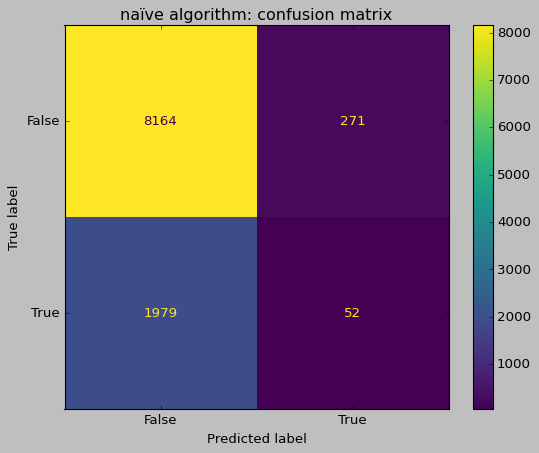

In [14]:
fig, ax = plt.subplots()
plot_confusion_matrix(mdl, X_test, y_true, ax=ax)
ax.set_title('naïve algorithm: confusion matrix')
fig.show()

## Ramdom Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

train_test_dis = pickle.load(open('data/train_test_dis.pkl', 'rb'))

In [16]:
X_train = train_test_dis['X_train_dis'].astype(float)
y_train = train_test_dis['y_train_dis']['congested'].astype(int)
X_test = train_test_dis['X_test_dis'].astype(float)
y_test = train_test_dis['y_test_dis']['congested'].astype(int)

In [17]:
mdl = RandomForestClassifier().fit(X_train, y_train)

In [18]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      8435
           1       0.21      0.44      0.28      2031

    accuracy                           0.57     10466
   macro avg       0.51      0.52      0.49     10466
weighted avg       0.70      0.57      0.61     10466



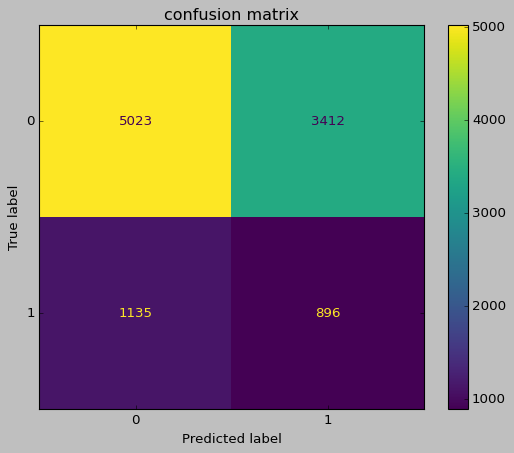

In [19]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

In [20]:
from sklearn.metrics import plot_roc_curve

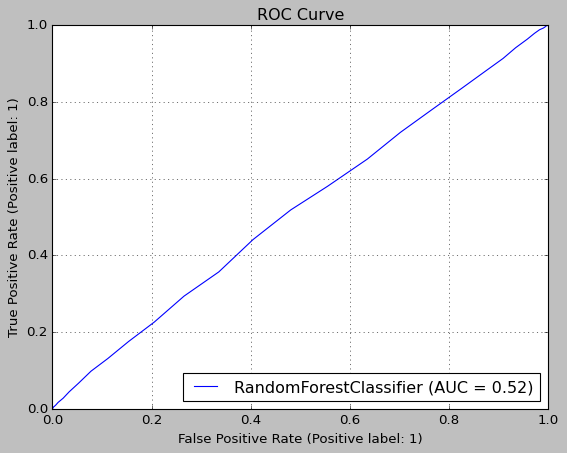

In [21]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Decision tree classifier

In [22]:
mdl = DecisionTreeClassifier().fit(X_train, y_train)

In [23]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.45      0.58      8435
           1       0.21      0.59      0.31      2031

    accuracy                           0.48     10466
   macro avg       0.51      0.52      0.44     10466
weighted avg       0.70      0.48      0.53     10466



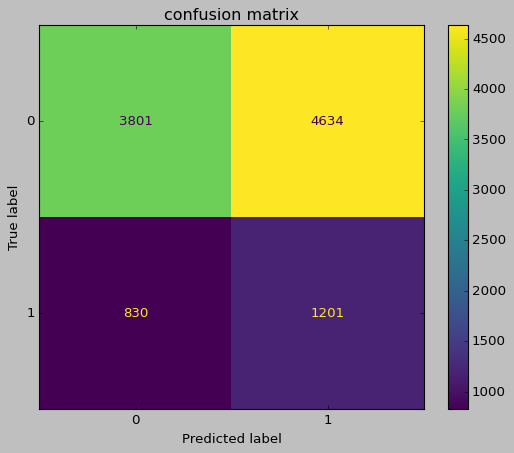

In [24]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

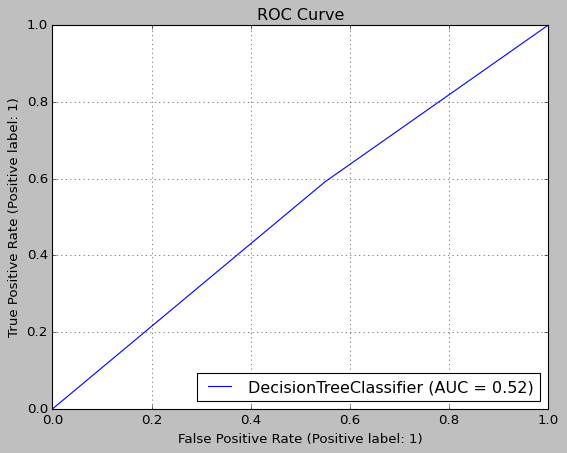

In [25]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## MLP classifier

In [26]:
mdl = MLPClassifier(hidden_layer_sizes=256).fit(X_train, y_train)

In [27]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      8435
           1       0.26      0.00      0.01      2031

    accuracy                           0.80     10466
   macro avg       0.53      0.50      0.45     10466
weighted avg       0.70      0.80      0.72     10466



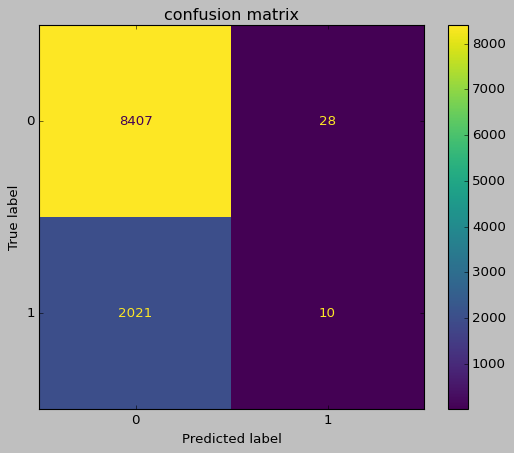

In [28]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

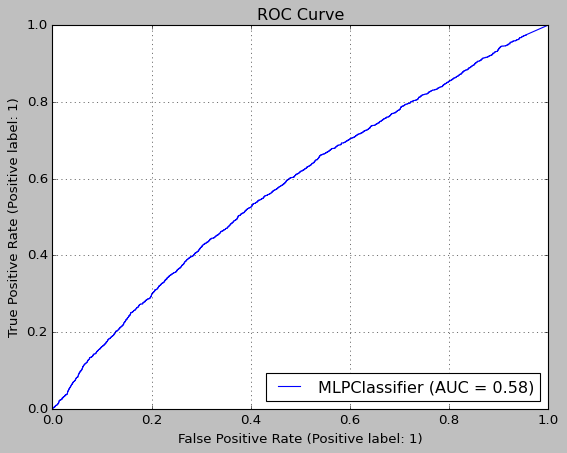

In [29]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Auto-ML Classifier

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor

ModuleNotFoundError: No module named 'autogluon'

In [31]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train.values

test_df = pd.DataFrame(X_test)
test_df['target'] = y_test.values

In [32]:
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

In [33]:
# predictor = TabularPredictor(
#     path='AutogluonModels/classifier',
#     label='target'
# ).fit(train_data)

predictor = TabularPredictor.load("AutogluonModels/classifier/")

In [34]:
predictor.leaderboard()

                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.793932       0.099904  179.332634                0.002139           0.367631            2       True         10
1      NeuralNetFastAI   0.791403       0.035460  172.721381                0.035460         172.721381            1       True          8
2             CatBoost   0.788875       0.006149    3.224838                0.006149           3.224838            1       True          5
3     RandomForestEntr   0.787611       0.056156    3.018784                0.056156           3.018784            1       True          4
4     RandomForestGini   0.785714       0.055114    2.544246                0.055114           2.544246            1       True          3
5       NeuralNetTorch   0.783186       0.027286   66.013871                0.027286          66.013871            1       True          9
6       ExtraTreesGini   0.

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.793932,0.099904,179.332634,0.002139,0.367631,2,True,10
1,NeuralNetFastAI,0.791403,0.035460,172.721381,0.035460,172.721381,1,True,8
2,CatBoost,0.788875,0.006149,3.224838,0.006149,3.224838,1,True,5
3,RandomForestEntr,0.787611,0.056156,3.018784,0.056156,3.018784,1,True,4
4,RandomForestGini,0.785714,0.055114,2.544246,0.055114,2.544246,1,True,3
5,NeuralNetTorch,0.783186,0.027286,66.013871,0.027286,66.013871,1,True,9
6,ExtraTreesGini,0.780657,0.056297,0.642430,0.056297,0.642430,1,True,6
7,ExtraTreesEntr,0.779393,0.055725,0.696730,0.055725,0.696730,1,True,7
8,KNeighborsDist,0.743363,0.418089,0.018924,0.418089,0.018924,1,True,2
9,KNeighborsUnif,0.742731,0.373856,0.018423,0.373856,0.018423,1,True,1


In [35]:
y_pred = predictor.predict(test_data)

In [36]:
print(classification_report(test_data['target'], y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8435
           1       0.46      0.03      0.06      2031

    accuracy                           0.80     10466
   macro avg       0.63      0.51      0.47     10466
weighted avg       0.74      0.80      0.73     10466



In [37]:
# wrapper
class AUTOPredictor(BaseEstimator):
    def __init__(self, classifier):
        self.classifier = classifier
        self._estimator_type = 'classifier'
        
    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.classifier.predict(X)
    
    def predict_proba(self, X):
        return self.classifier.predict_proba(X)
    

In [38]:
mdl = AUTOPredictor(classifier=predictor)

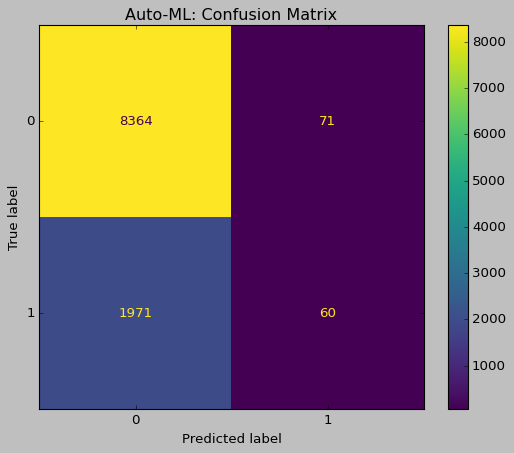

In [39]:
plot_confusion_matrix(mdl, test_data, test_data['target'])
plt.title('Auto-ML: Confusion Matrix')
plt.show()

In [40]:
import sklearn.metrics as metrics
import scikitplot as skplt

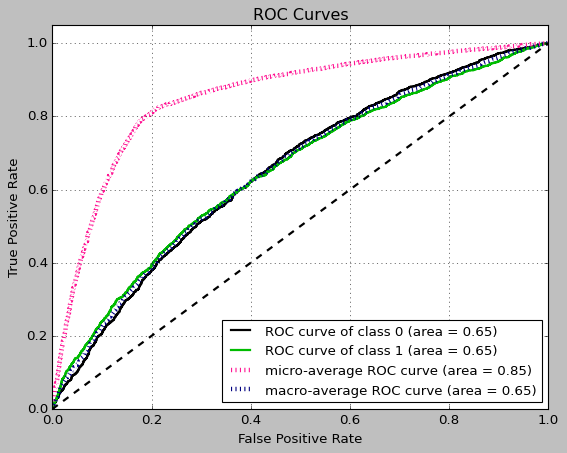

In [41]:
y_probs = predictor.predict_proba(test_data)
preds = y_probs[:][1]
y_true = test_data['target']

skplt.metrics.plot_roc_curve(y_true, y_probs)

plt.grid()
plt.show()


### Classification Under Different Threshold

# Regression

## Random Forest Regression

In [43]:
from sklearn.ensemble import RandomForestRegressor


In [44]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]


In [45]:
mdl = RandomForestRegressor().fit(
    train_data.loc[:, train_data.columns != 'theta_ma_future'],
    train_data.loc[:, train_data.columns == 'theta_ma_future'],
)


In [47]:
# calculate R2
from sklearn.metrics import r2_score

In [48]:
r2 = r2_score(test_data['theta_ma_future'],
              mdl.predict(
                  test_data.loc[:, train_data.columns != 'theta_ma_future'])
              )
print(f'R2 Score: {r2}')


R2 Score: -0.03339372756537484


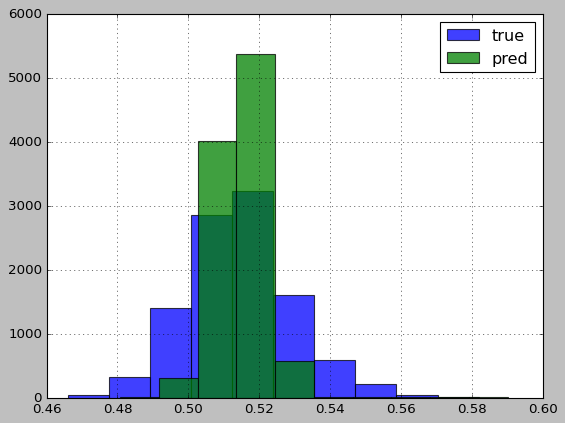

In [49]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(mdl.predict(
    test_data.loc[:, train_data.columns != 'theta_ma_future'])).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [77]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]


In [78]:
mdl = RandomForestRegressor().fit(
    train_data.loc[:, train_data.columns != 'theta'],
    train_data.loc[:, train_data.columns == 'theta'],
)


In [79]:
r2 = r2_score(test_data['theta'],
              mdl.predict(
                  test_data.loc[:, test_data.columns != 'theta'])
              )
print(f'R2 Score: {r2}')


R2 Score: 0.9027578700108659


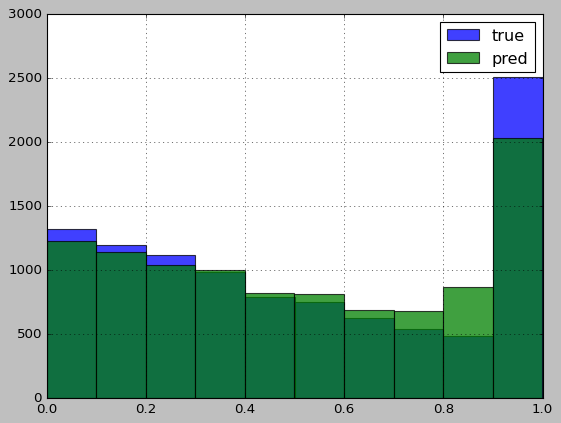

In [81]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(mdl.predict(
    test_data.loc[:, test_data.columns != 'theta'])).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


## Auto-ML

In [82]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [83]:
# predictor = TabularPredictor(
#     label='theta_ma_future',
#     path='AutogluonModels/regression/'
# ).fit(train_data)

predictor = TabularPredictor.load("AutogluonModels/regression/")


In [84]:
predictor.leaderboard(test_data)

                 model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetTorch   -0.014273  -0.019927        0.076693       0.013952  33.085686                 0.076693                0.013952          33.085686            1       True          7
1             CatBoost   -0.014369  -0.019596        0.003594       0.001807   1.139939                 0.003594                0.001807           1.139939            1       True          4
2  WeightedEnsemble_L2   -0.014385  -0.019469        0.299262       0.055514  20.895186                 0.003456                0.000239           0.107268            2       True          8
3      NeuralNetFastAI   -0.014395  -0.019494        0.073846       0.013327  17.421824                 0.073846                0.013327          17.421824            1       True          6
4        ExtraTreesMSE   -0.015150  -0.020030

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-0.014273,-0.019927,0.076693,0.013952,33.085686,0.076693,0.013952,33.085686,1,True,7
1,CatBoost,-0.014369,-0.019596,0.003594,0.001807,1.139939,0.003594,0.001807,1.139939,1,True,4
2,WeightedEnsemble_L2,-0.014385,-0.019469,0.299262,0.055514,20.895186,0.003456,0.000239,0.107268,2,True,8
3,NeuralNetFastAI,-0.014395,-0.019494,0.073846,0.013327,17.421824,0.073846,0.013327,17.421824,1,True,6
4,ExtraTreesMSE,-0.015150,-0.020030,0.178477,0.038914,0.651485,0.178477,0.038914,0.651485,1,True,5
5,RandomForestMSE,-0.015206,-0.020075,0.218366,0.040141,2.226155,0.218366,0.040141,2.226155,1,True,3
6,KNeighborsUnif,-0.016885,-0.022168,0.015674,0.007262,0.012152,0.015674,0.007262,0.012152,1,True,1
7,KNeighborsDist,-0.017574,-0.023070,0.023898,0.005272,0.008742,0.023898,0.005272,0.008742,1,True,2


In [85]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: 0.0544987971581381


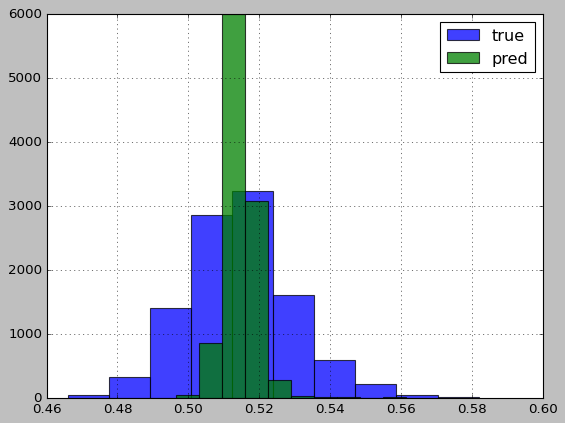

In [86]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [87]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

In [92]:
predictor = TabularPredictor(
    label='theta_ma_future',
    path='AutogluonModels/regression_theta/'
).fit(train_data)

predictor = TabularPredictor.load("AutogluonModels/regression_theta/")


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression_theta/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52329
Train Data Columns: 6
Label Column: theta_ma_future
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.6945601391516564, 0.43222634553184464, 0.51465, 0.01771)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3977.67 MB
	Train Data (Original)  Memory Usage: 2.15 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set

In [93]:
r2 = r2_score(test_data['theta'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: 0.010447958873932461


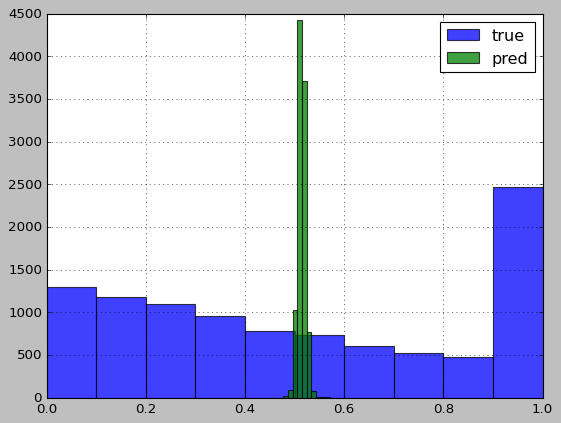

In [94]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


# Regression with Volatility

In [90]:
train_data = pd.read_pickle('data/train_volatility.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future', 'volatility']]
test_data = pd.read_pickle('data/test_volatility.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future', 'volatility']]


In [135]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [137]:
# predictor = TabularPredictor(
#     label='theta_ma_future',
#     path='AutogluonModels/regression-volatility/'
# ).fit(train_data)

predictor = TabularPredictor.load("AutogluonModels/regression-volatility/")


In [138]:
predictor.leaderboard(test_data)


                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      NeuralNetFastAI   -0.012858  -0.018600        0.027713       0.013725   17.867649                 0.027713                0.013725          17.867649            1       True          6
1       NeuralNetTorch   -0.013346  -0.019730        0.023737       0.014531  109.207122                 0.023737                0.014531         109.207122            1       True          7
2        ExtraTreesMSE   -0.013683  -0.016324        0.135954       0.040704    0.680541                 0.135954                0.040704           0.680541            1       True          5
3       KNeighborsUnif   -0.015780  -0.022814        0.007113       0.006224    0.008994                 0.007113                0.006224           0.008994            1       True          1
4       KNeighborsDist   -0.016309  -0.0

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,-0.012858,-0.018600,0.027713,0.013725,17.867649,0.027713,0.013725,17.867649,1,True,6
1,NeuralNetTorch,-0.013346,-0.019730,0.023737,0.014531,109.207122,0.023737,0.014531,109.207122,1,True,7
2,ExtraTreesMSE,-0.013683,-0.016324,0.135954,0.040704,0.680541,0.135954,0.040704,0.680541,1,True,5
3,KNeighborsUnif,-0.015780,-0.022814,0.007113,0.006224,0.008994,0.007113,0.006224,0.008994,1,True,1
4,KNeighborsDist,-0.016309,-0.023657,0.007478,0.007488,0.009057,0.007478,0.007488,0.009057,1,True,2
5,RandomForestMSE,-0.017029,-0.012926,0.131156,0.039746,2.245270,0.131156,0.039746,2.245270,1,True,3
6,WeightedEnsemble_L2,-0.018654,-0.012346,0.140865,0.043425,49.159545,0.002093,0.000264,0.109432,2,True,8
7,CatBoost,-0.022231,-0.012723,0.007616,0.003415,46.804843,0.007616,0.003415,46.804843,1,True,4


In [139]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: -1.0998245808838147


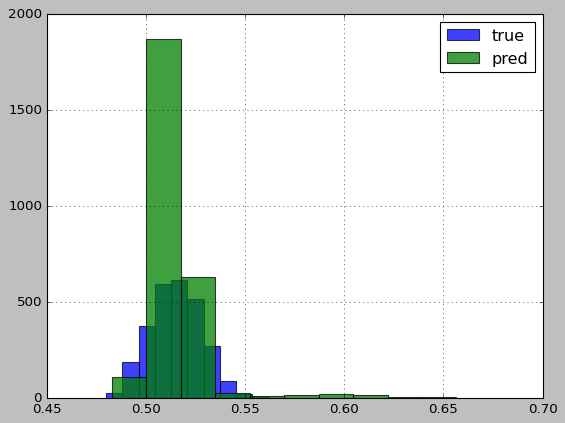

In [140]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [95]:
train_data = pd.read_pickle('data/train_volatility.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev', 'theta_ma_future', 'volatility']]
test_data = pd.read_pickle('data/test_volatility.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev', 'theta_ma_future', 'volatility']]


In [97]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [98]:
# predictor = TabularPredictor(
#     label='theta_ma_future',
#     path='AutogluonModels/regression-volatility-theta/'
# ).fit(train_data)

predictor = TabularPredictor.load(
    "AutogluonModels/regression-volatility-theta/")


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression-volatility-theta/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52329
Train Data Columns: 5
Label Column: theta_ma_future
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.6945601391516564, 0.43222634553184464, 0.51465, 0.01771)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4046.89 MB
	Train Data (Original)  Memory Usage: 2.09 MB (0.1% of available memory)
	Inferring data type of each feature based on column 

In [99]:
predictor.leaderboard(test_data)


                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      NeuralNetFastAI   -0.014516  -0.017564        0.084895       0.019238   81.228218                 0.084895                0.019238          81.228218            1       True          6
1       NeuralNetTorch   -0.014822  -0.017637        0.074625       0.021565  337.467853                 0.074625                0.021565         337.467853            1       True          7
2        ExtraTreesMSE   -0.014839  -0.017309        0.284420       0.055431    2.228918                 0.284420                0.055431           2.228918            1       True          5
3      RandomForestMSE   -0.015544  -0.015870        0.396808       0.054574   10.840518                 0.396808                0.054574          10.840518            1       True          3
4  WeightedEnsemble_L2   -0.015755  -0.0

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,-0.014516,-0.017564,0.084895,0.019238,81.228218,0.084895,0.019238,81.228218,1,True,6
1,NeuralNetTorch,-0.014822,-0.017637,0.074625,0.021565,337.467853,0.074625,0.021565,337.467853,1,True,7
2,ExtraTreesMSE,-0.014839,-0.017309,0.284420,0.055431,2.228918,0.284420,0.055431,2.228918,1,True,5
3,RandomForestMSE,-0.015544,-0.015870,0.396808,0.054574,10.840518,0.396808,0.054574,10.840518,1,True,3
4,WeightedEnsemble_L2,-0.015755,-0.015176,0.411031,0.058860,54.084167,0.002274,0.000221,0.108201,2,True,8
5,CatBoost,-0.016263,-0.015325,0.011949,0.004065,43.135448,0.011949,0.004065,43.135448,1,True,4
6,KNeighborsUnif,-0.016555,-0.020116,0.015765,0.006929,0.028194,0.015765,0.006929,0.028194,1,True,1
7,KNeighborsDist,-0.017060,-0.020467,0.015737,0.007029,0.027825,0.015737,0.007029,0.027825,1,True,2


In [100]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: -0.12270674494127065


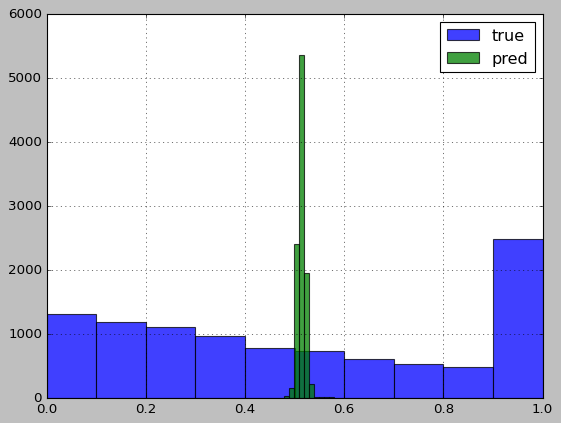

In [101]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()
